# Building final model

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

/var/folders/gp/n7ttdtg56pg0s6ydv9zj9wth0000gn/T/ipykernel_2922/1543584708.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import calendar
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from xgboost import XGBClassifier

## Essential Functions for Model Generation

In [3]:
TARGET_VALUE = 'y'

def get_training_data():
    df = pd.read_csv("datasource/bank_data_model.csv")
    return df.iloc[:,1:]

def get_validation_data():
    df =  pd.read_csv("datasource/bank_data_validate.csv")
    return df.iloc[:,1:]

def get_categorical_features(dataFrame): 
    return dataFrame.drop(columns=get_numerical_features(dataFrame)).columns.values

def get_numerical_features(dataFrame):
    return dataFrame.select_dtypes(include=np.number).columns.values

def get_numerical_features_transformer():
    class DayMonthTransformer(BaseEstimator,TransformerMixin):
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            X_transformed = X.copy()
            month_num_dict = {month.lower(): index for index, month in enumerate(calendar.month_abbr) if month}
            X_transformed['month'] = X_transformed['month'].map(month_num_dict)
            X_transformed['year'] = np.repeat(2024, repeats= X_transformed.shape[0])
            X_transformed['day_of_the_year'] = pd.to_datetime(X_transformed[["year","month","day"]], format='%d/%m/%y', errors='coerce')
            X_transformed['day_of_the_year'] = X_transformed['day_of_the_year'].apply(lambda x: x.dayofyear)
            return X_transformed.drop(columns=["day", "month", "year"])
        
        def get_feature_names_out(self, input_features = None):
            return ['day_of_the_year']
        
    return ColumnTransformer(
        transformers=[
            ("duration", PowerTransformer(method="yeo-johnson"), ["duration"]),
            ("age", Pipeline( steps = [
                                ("age_power_transform", PowerTransformer(method="box-cox")),
                                ("age_function_transform", FunctionTransformer(lambda col : col + abs(np.min(col)), feature_names_out='one-to-one'))
                                ]
                            ),
            ["age"]),
            ("balance", Pipeline( steps = [
                                ("balance_function_transform_min", FunctionTransformer(lambda col : col + abs(np.min(col)),feature_names_out='one-to-one')),
                                ("balance_function_transform_log", FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
                                ]
                            ),
            ["balance"]),
            ("day_of_the_year", DayMonthTransformer(), ["day","month"])
            ]
        )
                        
def get_categorical_features_transformer():
    poutcome_dict = {"failure":0, "other": 0.25, "unknown": 0.5, "success": 1}
    education_dict = {'unknown' : 0, 'secondary' : 0.5, 'tertiary' : 1, 'primary' : 0.25}
    maritial_dict = {"single" : 0, "divorced" : 0.5, "married"  : 1}
    pd.set_option('future.no_silent_downcasting', True)
    return ColumnTransformer(
        transformers= [
            ("yes_no_variables",  OrdinalEncoder(), ["default", "housing", "loan"]),
            ("ordered1", FunctionTransformer(lambda col: col.replace(education_dict), feature_names_out='one-to-one'), ["education"]),
            ("ordered2", FunctionTransformer(lambda col: col.replace(poutcome_dict), feature_names_out='one-to-one'), ["poutcome"]),
            ("ordered3", FunctionTransformer(lambda col: col.replace(maritial_dict), feature_names_out='one-to-one'), ["marital"]),
            ("unsorted", OneHotEncoder(), ["job", "contact"]),
        ]
    )  

def get_features_transformer():
    return ColumnTransformer(
        transformers = [
            ("num", get_numerical_features_transformer(), ["duration","balance", "age", "day", "month"]),
            ("cat", get_categorical_features_transformer(), ["default", "housing", "loan", "education", "marital", "poutcome", "job", "contact"]),
            ("others", FunctionTransformer(feature_names_out='one-to-one'), ["campaign", "pdays","previous"])
        ]
    )

def get_estimator(weights):
    return XGBClassifier(booster= 'gbtree', 
                         eta= 0.10987358313376537,
                         max_delta_step= 1.446953199095078, 
                         max_depth= 4, 
                         min_child_weight= 1.666061864206202, 
                         objective= 'binary:logistic', 
                         scale_pos_weight= weights, 
                         tree_method= 'exact')
def get_model(weights):
    return Pipeline(
        steps = [
            ("preprocessor", get_features_transformer()),
            ("estimator", get_estimator(weights))
        ]
    )

def printMetrics(test, pred): 
    cm = confusion_matrix(test,pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    print(f"accuracy : {accuracy_score(test, pred)}")
    print(f"f1       : {f1_score(test, pred)}")
    print(f"precision: {precision_score(test, pred)}")
    print(f"recall   : {recall_score(test, pred)}")
    print(f"roc_auc  : {roc_auc_score(test,pred)}")

## Loading raw data. Data split. Target variable encoding

In [4]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split

df = get_training_data()
le = LabelEncoder()
df[TARGET_VALUE] = le.fit_transform(df[TARGET_VALUE])

X_train, X_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df[TARGET_VALUE],
    random_state=42,
)

y_train, y_test = X_train[TARGET_VALUE], X_test[TARGET_VALUE]
X_train, X_test = X_train.drop(columns=TARGET_VALUE), X_test.drop(columns=TARGET_VALUE)

## Model generation

In [5]:
positive = y_train.sum()
negative = y_train.count() - positive
clf = get_model(negative/positive)

In [6]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(transformers=[('duration',
                                                                                   PowerTransformer(),
                                                                                   ['duration']),
                                                                                  ('age',
                                                                                   Pipeline(steps=[('age_power_transform',
                                                                                                    PowerTransformer(method='box-cox')),
                                                                                                   ('age_function_transform',
                                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                        func=<function get_numerical_features_transf...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None,
                               max_delta_step=1.446953199095078, max_depth=4,
                               max_leaves=None,
                               min_child_weight=1.666061864206202, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [7]:
clf[:-1].get_feature_names_out()

array(['num__duration__duration', 'num__age__age',
       'num__balance__balance', 'num__day_of_the_year__day_of_the_year',
       'cat__yes_no_variables__default', 'cat__yes_no_variables__housing',
       'cat__yes_no_variables__loan', 'cat__ordered1__education',
       'cat__ordered2__poutcome', 'cat__ordered3__marital',
       'cat__unsorted__job_admin.', 'cat__unsorted__job_blue-collar',
       'cat__unsorted__job_entrepreneur', 'cat__unsorted__job_housemaid',
       'cat__unsorted__job_management', 'cat__unsorted__job_retired',
       'cat__unsorted__job_self-employed', 'cat__unsorted__job_services',
       'cat__unsorted__job_student', 'cat__unsorted__job_technician',
       'cat__unsorted__job_unemployed', 'cat__unsorted__job_unknown',
       'cat__unsorted__contact_cellular',
       'cat__unsorted__contact_telephone',
       'cat__unsorted__contact_unknown', 'others__campaign',
       'others__pdays', 'others__previous'], dtype=object)

## Model test

accuracy : 0.8756906077348067
f1       : 0.5754716981132075
precision: 0.4728682170542636
recall   : 0.7349397590361446
roc_auc  : 0.8144277578332049


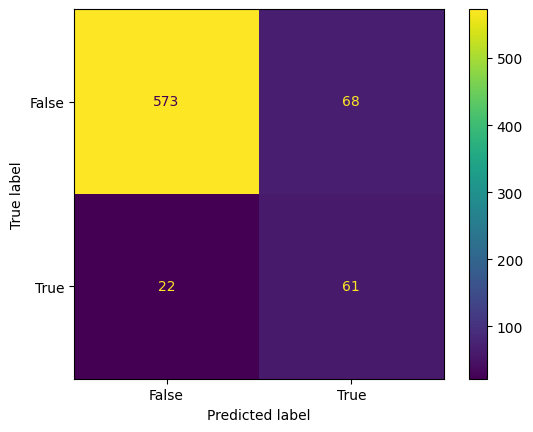

In [8]:
y_hat = clf.predict(X_test)
printMetrics(y_test, y_hat)

In [9]:
import dalex as dx

In [27]:
exp = dx.Explainer(clf, X_test, y_test)
mp = exp.model_performance(model_type = 'classification', cutoff=0.5)

Preparation of a new explainer is initiated

  -> data              : 724 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 724 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fd6ca84f790> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00027, mean = 0.217, max = 0.972
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.957, mean = -0.102, max = 0.999
  -> model_info        : package sklearn

A new explainer has been created!


In [28]:
mp.plot(geom="roc")

In [29]:
mp.result

,recall,precision,f1,accuracy,auc
XGBClassifier,0.73494,0.472868,0.575472,0.875691,0.911415


In [30]:
mp.plot()

In [31]:
vi = exp.model_parts(N = None, B = 20, random_state=42)
vi.plot()